In [60]:
import cobra.test
import mocbapy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd

# test.py by Marko

In [2]:
test_arr = list()
n_test = 2
for i in range(n_test):
    model = cobra.test.create_test_model("ecoli")
    model.id = model.id + '_' + str(i+1)
    test_arr.append(model)

In [3]:
common_mets = mocbapy.get_common_mets(test_arr)
test_EcoSys = mocbapy.create_model(model_array=test_arr, metabolic_dict=common_mets)

index_gluc_pool = test_EcoSys.sysreactions.index("EX_glc__D_e:pool")
test_EcoSys.lb[index_gluc_pool] = -5

In [4]:
bensolve_opts = mocbapy.bensolve_default_options
bensolve_opts['message_level'] = 0
sol_mofba = mocbapy.mo_fba(test_EcoSys, options=bensolve_opts)
print(sol_mofba)

(0, 7)
(1, 2590)
/var/folders/hv/r4rp10lx5nnc3q1x5ht0cl2w0000gn/T/tmp9facbo8u
c:[1.0, 1.0]
Primal
+--------+------+-------------------------+-----------+
| Vertex | Type |          Value          | Adjacency |
+--------+------+-------------------------+-----------+
|   0    |  0   |        [-1.  0.]        |   [2, 1]  |
|   1    |  0   |        [ 0. -1.]        |   [4, 0]  |
|   2    |  1   | [0.         0.47131026] |   [0, 3]  |
|   3    |  1   | [0.03649627 0.43509197] |   [5, 2]  |
|   4    |  1   | [0.47131026 0.        ] |   [1, 5]  |
|   5    |  1   | [0.43509197 0.03649627] |   [3, 4]  |
+--------+------+-------------------------+-----------+
+----------------+---------------------+
| Vertex of Dual | Incidence in Primal |
+----------------+---------------------+
|       0        |        [0, 1]       |
|       1        |        [4, 1]       |
|       2        |        [2, 0]       |
|       3        |        [3, 5]       |
|       4        |        [2, 3]       |
|       5     

/Users/mcortes/projects/activos/Markopy/mocbapy/mocbapy/procedures.py:47 UserWarning: 
Pre image was not saved, preimage value set to None. Include 'solution':True in problem options dictionary


In [5]:
sol_mofba

In [7]:
sol_mofba.Primal.vertex_value

array([[-1.        ,  0.        ],
       [ 0.        , -1.        ],
       [ 0.        ,  0.47131026],
       [ 0.03649627,  0.43509197],
       [ 0.47131026,  0.        ],
       [ 0.43509197,  0.03649627]])

In [65]:
m=pd.DataFrame(sol_mofba.Primal.vertex_value[np.array(sol_mofba.Primal.vertex_type)==1],columns=["x","y"])

In [66]:
m.sort_values("x",inplace=True)

In [67]:
m

,x,y
0,0.000000,0.471310
1,0.036496,0.435092
3,0.435092,0.036496
2,0.471310,0.000000


In [57]:
a

array([[0.        , 0.47131026],
       [0.03649627, 0.43509197],
       [0.47131026, 0.        ],
       [0.43509197, 0.03649627]])

# ParetoGrid Class

In [254]:
class ParetoGrid:
  
        x = None #id model 1
        y = None #id model 2
        objx = None # objective function ID model 1
        objy = None # objective function ID model 2
        emodel = None # EcosystemModel object made from model 1 and 2
        front = None # data frame with sorted (x axis) pareto front points
        step = None # complex value to set grid density 
        points = None # array of grid points below the front              
        zID = None # ID of function plotted on the grid
        z = None # array of plotted function values for each grid point
        unfeasible = None # array of booleans indicating points in grid with unfeasible values for plotted function

        
        def __init__(self, emodel, sol_mofba, modelIDs=['model1','model2'], step=30j):
            
            """
            Instantiate the ParetoGrid object. 
            emodel: EcosystemModel object (for now: only two org systems considered)
            sol_mofba: bensolve solution for the EcosystemModel
            modelIDs: List of IDs of the two single-org models used to build the EcosystemModel
            step: complex number 
            """
            self.x, self.y = modelIDs
            self.emodel = emodel
            self.objx = emodel.objectives[emodel.models[0]][0][0]
            self.objy = emodel.objectives[emodel.models[1]][0][0]
            self.step = step
            self.front = self._setFront(sol_mofba)
            self._setPoints()

        def _setPoints(self):
            
            """
            Sets array of (x,y) points below the Pareto front that make the grid 
            step parameter sets grid point density 
            """
            
            #rectangular grid:
            xmin = self.front[self.x].min()
            xmax = self.front[self.x].max()
            ymin = self.front[self.y].min()
            ymax = self.front[self.y].max()

            gx, gy = np.mgrid[xmin:xmax:self.step,ymin:ymax:self.step]
            positions = np.column_stack((gx.ravel(), gy.ravel()))

            # Assuming objective functions can only take positive values ..
            y_lb = 0 
            x_lb = 0

            #Only points in polygon between the pareto front and x,y axes are kept in the grid
            polypoints = np.vstack(([x_lb,y_lb],self.front[[self.x,self.y]].values,[xmax,y_lb]))
            path = Path(polypoints, closed = True) # closed argument not needed ...
            IsInside = path.contains_points(positions)

            self.points = positions[IsInside]

        
        
        def _setFront(self,sol_mofba):
            
            """
            Sets Pareto front values that shape the grid
            sol_mofba: bensolve solution for the EcosystemModel
            returns DataFrame of sorted Pareto points
            """
            
            vv = sol_mofba.Primal.vertex_value[np.array(sol_mofba.Primal.vertex_type)==1]
            front=pd.DataFrame(data = vv, columns = [self.x,self.y])
            front.sort_values(self.x, inplace=True)
            return front
        
        def randomNormal2grid(self,n = 1,unfeasible_frac = 0.05):
            """
            Esta función es un jugo que plotea valores random en la grilla.
            La armé para testear los plots. La borramos cuando este definido el fva
            """
            
            # this is just to test grid plots
            self.zID = 'Random_coloromics'
            npoints = len(self.points)
            random_values = np.random.normal(size=npoints*n)
            self.z = np.reshape(random_values, (npoints,n))
            
           # testing unfeasible juice
            num_uf = int(len(self.points)*unfeasible_frac)
            index_uf = np.random.choice(npoints, size=num_uf, replace=False)
            self.unfeasible = np.in1d(np.arange(npoints),index_uf) 
           
        
        def get_feasible_points(self):
            """Returns grid points with feasible values for plotted function"""
            
            return self.points[~self.unfeasible]
        
        def get_feasible_z(self):
            """Returns plotted function values for grid points with feasible values"""
            
            return self.z[~self.unfeasible]
            
        def plotGrid(self,cmap="jet",s=5,dpi=100,figsize=(8, 4),fontsize=12,background="white"):
            """
            Plots ParetoGrid. MP Beta release.
            """
            
            
            clean_points = self.get_feasible_points()
            clean_z=self.get_feasible_z()
            
            #plotted values range
            zmin = self.z.min()
            zmax = self.z.max()
            
            
            #number of subplots
            nc = self.z.shape[1]
                    
            # figure and subplots settings
            #fig, axes = plt.subplots(figsize=figsize, dpi=dpi,nrows = 1, ncols=nc,
            #                         sharex=False, sharey = 'row')
            
            fig, axes = plt.subplots(squeeze=False, figsize=figsize, dpi=dpi,nrows = 1, 
                                     ncols=nc,sharex=False, sharey = 'row')
            axs = axes.ravel()
            fig.suptitle(self.zID)
            for zi in range(nc):
                ax = axs[zi]
                self.front.plot(ax=ax,kind="line", x=self.x, y =self.y,legend=False)    
                im = ax.scatter(clean_points[:,0],clean_points[:,1],
                              c=clean_z[:,zi],cmap=plt.get_cmap(cmap),s=s,vmin=zmin, vmax=zmax) 
                ax.set(xlabel=self.x, ylabel=self.y)
                ax.set_facecolor(background)
                for xtick in ax.get_xticklabels():
                    xtick.set_fontsize(fontsize*0.7)
                    xtick.set_rotation(45)
                for ytick in ax.get_yticklabels():
                    ytick.set_fontsize(fontsize*0.7)
        
            #Colorbar adjustments 
            fig.subplots_adjust(left=0.05)
            pos = im.axes.get_position()
            x0 = pos.x0 + pos.width +0.01
            y0 = pos.y0 + pos.height*0.15
            w  = 0.02
            h  = pos.height*0.7
            cbar_ax = fig.add_axes([x0, y0, w, h])
            fig.colorbar(im, orientation ='vertical',cax=cbar_ax)

In [255]:
mygrid = ParetoGrid(emodel = test_EcoSys, sol_mofba=sol_mofba,modelIDs=['model1','model2'], step=30j)

In [260]:
mygrid.randomNormal2grid(n=3)

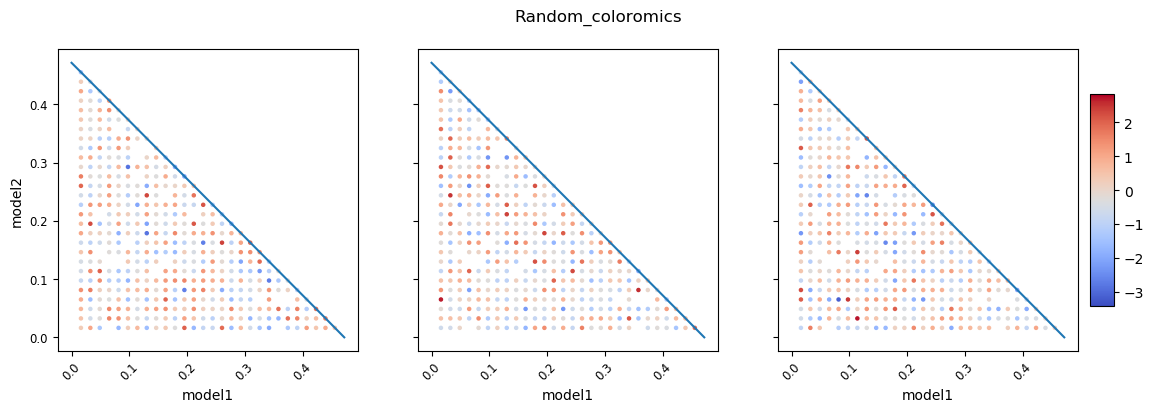

In [263]:
mygrid.plotGrid(background="white",fontsize=12,figsize=(12,4),cmap='coolwarm')

In [251]:
type(mygrid.points)

numpy.ndarray